**Patient No-Show Prediction System**

OBJECTIVE

1. The primary objective of this project is to analyze and predict patient appointment no-shows using the KaggleV2-May-2016 healthcare dataset.
The goal is to:

2. Identify key factors influencing patient no-shows.

3. Build and compare multiple machine learning models (Logistic Regression, Random Forest, XGBoost) to predict no-show probability.

4. Evaluate model fairness across demographic groups (gender, age).

5. Apply explainable AI (SHAP and LIME) techniques to interpret model decisions and ensure transparency.

Approach

1. Data Preprocessing: Removed irrelevant IDs, encoded target (No-Show → 0/1), derived features (waiting_days, appointment_weekday), cleaned invalid data, one-hot encoded categorical variables, and scaled numerical features.

2. EDA: Visualized distributions of age, waiting_days, and gender vs no_show to identify trends like higher no-shows with longer waiting periods.

3. Model Development: Built Logistic Regression, Random Forest, and XGBoost models; evaluated using Accuracy, Precision, Recall, F1, and ROC-AUC; compared results via charts and heatmaps.

4. Model Selection: XGBoost performed best and was saved with scaler, feature columns, and metadata for deployment.

5. Fairness Analysis: Evaluated gender and age bias using statistical parity and equalized odds; results showed minimal disparity.

6. Explainability: Applied SHAP for global and local feature interpretation and LIME for local explanations; SHAP proved more consistent and reliable.

**A**. No-show Predictive Analysis

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb
from sklearn.metrics import roc_curve, auc



1. Dataset

In [ ]:
# Load dataset
df = pd.read_csv("/content/KaggleV2-May-2016.csv")

df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


2. Data Preprocessing

In [ ]:
# Drop irrelevant ID columns first
df = df.drop(columns=['PatientId', 'AppointmentID'])

# Make all column names lowercase
df.columns = df.columns.str.lower()

# Encode target variable
df['no_show'] = df['no-show'].map({'No': 0, 'Yes': 1})
df = df.drop(columns=['no-show'])

# Convert datetime columns
df['scheduledday'] = pd.to_datetime(df['scheduledday'])
df['appointmentday'] = pd.to_datetime(df['appointmentday'])

# Create new features
df['waiting_days'] = (df['appointmentday'] - df['scheduledday']).dt.days
df['appointment_weekday'] = df['appointmentday'].dt.dayofweek  # 0=Mon

# Drop original datetime columns
df = df.drop(columns=['scheduledday', 'appointmentday'])

# Encode categorical variables
df['gender'] = df['gender'].map({'F': 0, 'M': 1})

# One-hot encode neighbourhood
df = pd.get_dummies(df, columns=['neighbourhood'], drop_first=True)

# Remove negative waiting days
df = df[df['waiting_days'] >= 0]

# Remove unrealistic ages
df = df[(df['age'] >= 0) & (df['age'] <= 100)]

# Final check
print(df.shape)
print(df.head())

# Train-Test Split
X = df.drop(columns=['no_show'])
y = df['no_show']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(71954, 91)
    gender  age  scholarship  hipertension  diabetes  alcoholism  handcap  \
5        0   76            0             1         0           0        0   
6        0   23            0             0         0           0        0   
7        0   39            0             0         0           0        0   
9        0   19            0             0         0           0        0   
10       0   30            0             0         0           0        0   

    sms_received  no_show  waiting_days  ...  neighbourhood_SANTOS REIS  \
5              0        0             1  ...                      False   
6              0        1             1  ...                      False   
7              0        1             1  ...                      False   
9              0        0             1  ...                      False   
10             0        0             1  ...                      False   

    neighbourhood_SEGURANÇA DO LAR  neighbourhood_SOLON BORGES  \
5       

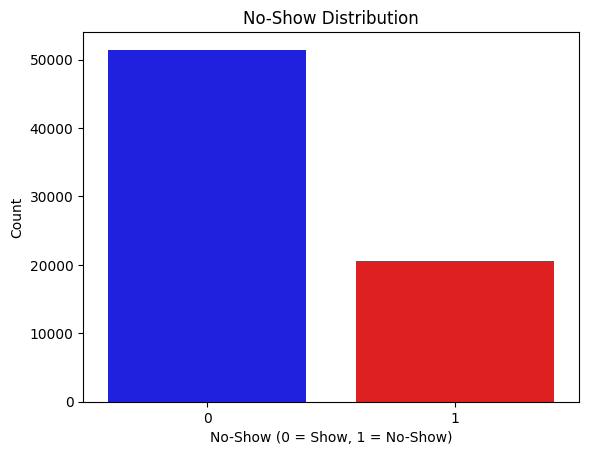

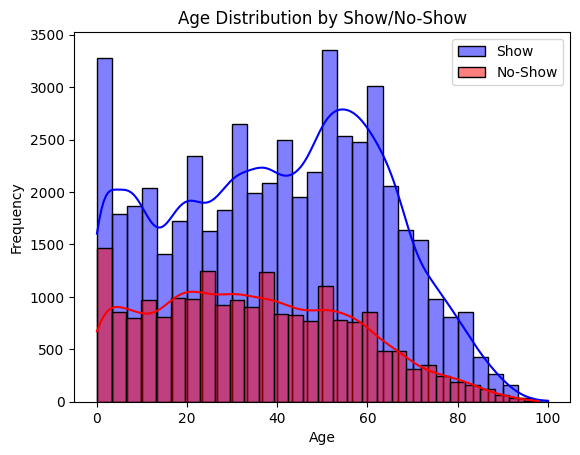

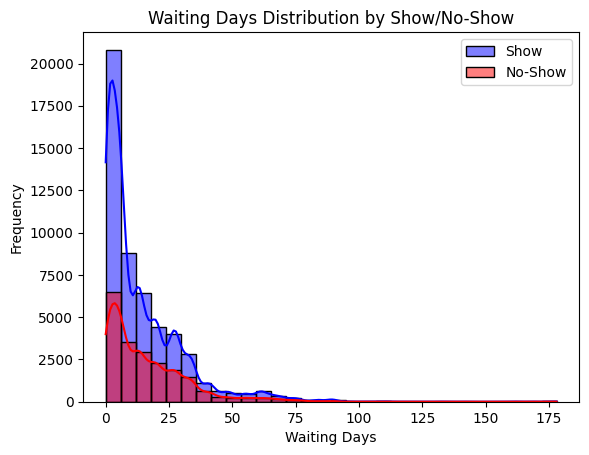

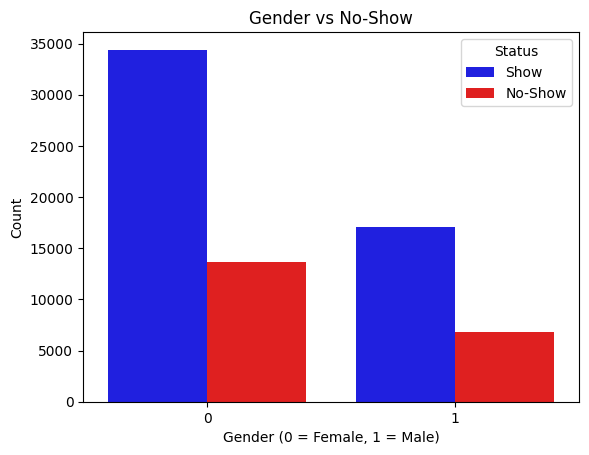

In [ ]:
# Visualizations
# Custom palette (Show = blue, No-show = red)
custom_palette = {0: "blue", 1: "red"}

# No-Show Distribution
sns.countplot(x='no_show', data=df, palette=custom_palette, hue='no_show', legend=False)
plt.title("No-Show Distribution")
plt.xlabel("No-Show (0 = Show, 1 = No-Show)")
plt.ylabel("Count")
plt.show()

# Age Distribution
sns.histplot(df[df['no_show'] == 0]['age'], bins=30, kde=True, color='blue', label='Show')
sns.histplot(df[df['no_show'] == 1]['age'], bins=30, kde=True, color='red', label='No-Show')
plt.title("Age Distribution by Show/No-Show")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Waiting Days Distribution
sns.histplot(df[df['no_show'] == 0]['waiting_days'], bins=30, kde=True, color='blue', label='Show')
sns.histplot(df[df['no_show'] == 1]['waiting_days'], bins=30, kde=True, color='red', label='No-Show')
plt.title("Waiting Days Distribution by Show/No-Show")
plt.xlabel("Waiting Days")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Gender vs No-Show
sns.countplot(x='gender', hue='no_show', data=df, palette=custom_palette)
plt.title("Gender vs No-Show")
plt.xlabel("Gender (0 = Female, 1 = Male)")
plt.ylabel("Count")
plt.legend(title='Status', labels=['Show', 'No-Show'])
plt.show()

3. Model Training & Prediction

3.1 Logistic Regression

In [ ]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

y_pred_lr = model.predict(X_test_scaled)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1-Score:", f1_score(y_test, y_pred_lr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression
Accuracy: 0.714265860607324
Precision: 0.4230769230769231
Recall: 0.005360623781676413
F1-Score: 0.010587102983638113

Confusion Matrix:
 [[10257    30]
 [ 4082    22]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      1.00      0.83     10287
           1       0.42      0.01      0.01      4104

    accuracy                           0.71     14391
   macro avg       0.57      0.50      0.42     14391
weighted avg       0.63      0.71      0.60     14391



3.2 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train_scaled, y_train)

y_pred_rf = model_rf.predict(X_test_scaled)

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-Score:", f1_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest
Accuracy: 0.6939059134181086
Precision: 0.42843556823585355
Recall: 0.219541910331384
F1-Score: 0.29031738359916226

Confusion Matrix:
 [[9085 1202]
 [3203  901]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.88      0.80     10287
           1       0.43      0.22      0.29      4104

    accuracy                           0.69     14391
   macro avg       0.58      0.55      0.55     14391
weighted avg       0.65      0.69      0.66     14391



3.3 XGBoost

In [ ]:
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)
y_prob_xgb = model_xgb.predict_proba(X_test)[:,1]

print("XGBoost")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1-Score:", f1_score(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:11:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost
Accuracy: 0.7147522757278855
Precision: 0.4991596638655462
Recall: 0.07236842105263158
F1-Score: 0.1264098744413705

Confusion Matrix:
 [[9989  298]
 [3807  297]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.97      0.83     10287
           1       0.50      0.07      0.13      4104

    accuracy                           0.71     14391
   macro avg       0.61      0.52      0.48     14391
weighted avg       0.66      0.71      0.63     14391



4. Model Comparison

4.1 Comparison Table

In [ ]:
results = { "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
     "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_xgb)],
    "Precision": [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_xgb)],
    "Recall": [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_xgb)],
    "F1-Score": [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_xgb)]
    }
comparison_df = pd.DataFrame(results)
print(comparison_df)

                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.714266   0.423077  0.005361  0.010587
1        Random Forest  0.693906   0.428436  0.219542  0.290317
2              XGBoost  0.714752   0.499160  0.072368  0.126410


4.2 Bar Plot & Heatmap

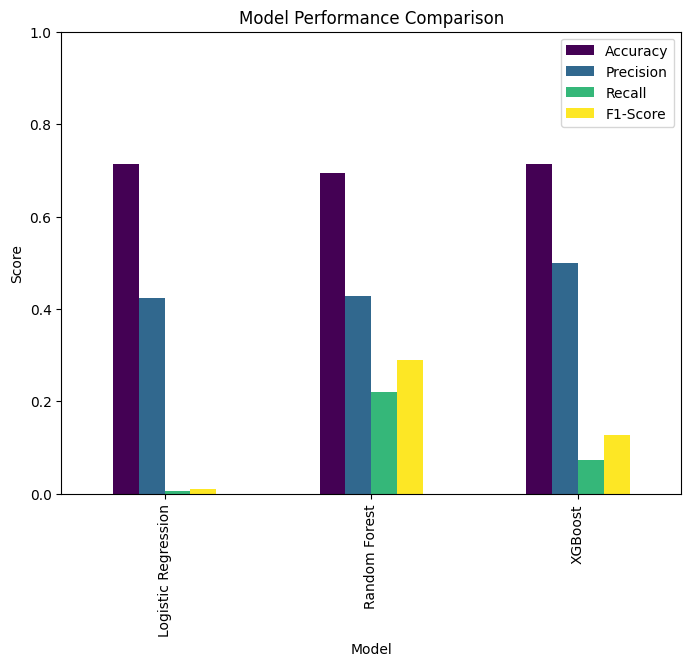

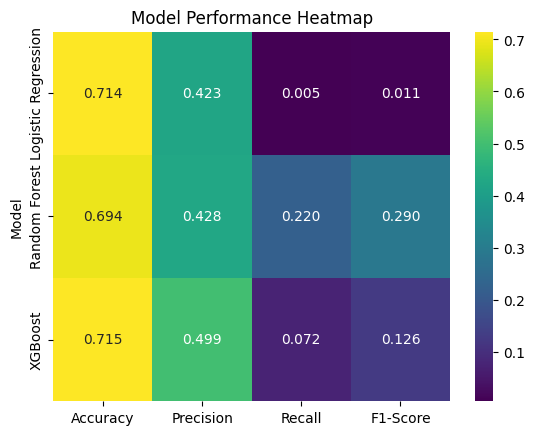

In [ ]:
comparison_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score"]].plot(
    kind="bar", figsize=(8, 6), colormap="viridis")

plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

sns.heatmap(comparison_df.set_index("Model"), annot=True, cmap="viridis", fmt=".3f")
plt.title("Model Performance Heatmap")
plt.show()


 4.3 Confusion Matrices

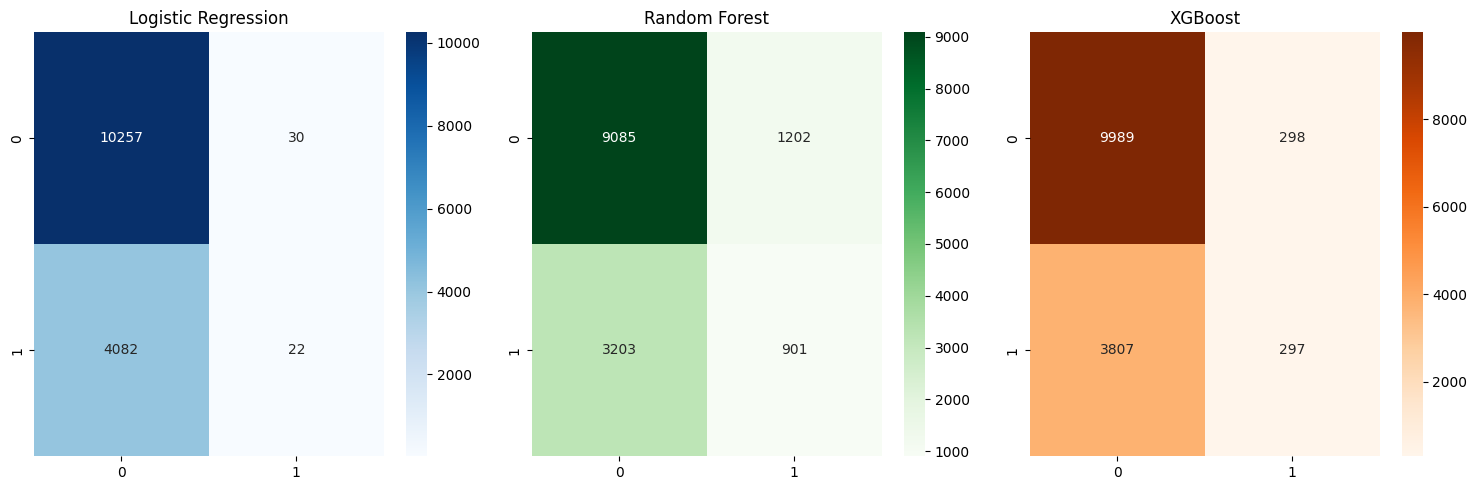

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap="Blues", ax=axes[0])
axes[0].set_title("Logistic Regression")

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap="Greens", ax=axes[1])
axes[1].set_title("Random Forest")

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap="Oranges", ax=axes[2])
axes[2].set_title("XGBoost")

plt.tight_layout()
plt.show()

4.4 ROC Curves + AUC

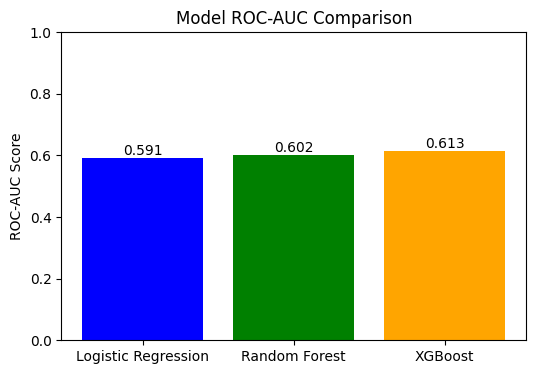

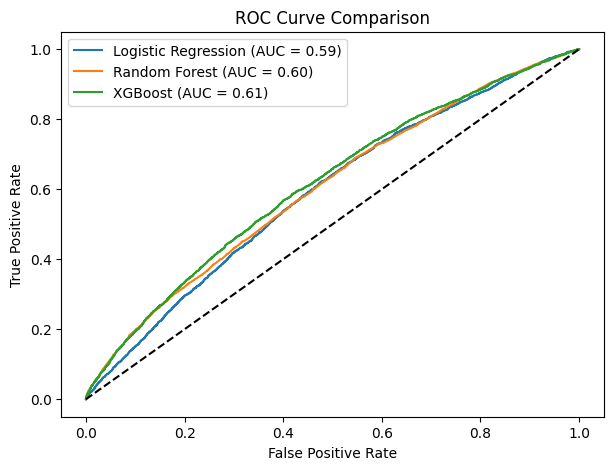

Logistic Regression: 0.5912
Random Forest: 0.6021
XGBoost: 0.6133

Best Model: XGBoost (AUC: 0.6133)


In [ ]:
# Logistic Regression
y_prob_lr = model.predict_proba(X_test_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)

# Random Forest
y_prob_rf = model_rf.predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

# XGBoost already done
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

# Create the models_auc dictionary
models_auc = {
    "Logistic Regression": auc_lr,
    "Random Forest": auc_rf,
    "XGBoost": auc_xgb }


#barplot
plt.figure(figsize=(6, 4))
plt.bar(models_auc.keys(), models_auc.values(), color=["blue", "green", "orange"])
plt.title("Model ROC-AUC Comparison")
plt.ylabel("ROC-AUC Score")
plt.ylim(0, 1)
for i, v in enumerate(models_auc.values()):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=10)
plt.show()


plt.figure(figsize=(7, 5))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# Find best model by ROC-AUC
best_model = max(models_auc, key=models_auc.get)

# Print all model AUCs
for model_name, auc_score in models_auc.items():
    print(f"{model_name}: {auc_score:.4f}")

print(f"\nBest Model: {best_model} (AUC: {models_auc[best_model]:.4f})")

XGBoost Model

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [19:12:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


===== XGBoost Model Performance =====
Accuracy:  0.7148
Precision: 0.4992
Recall:    0.0724
F1-Score:  0.1264

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.97      0.83     10287
           1       0.50      0.07      0.13      4104

    accuracy                           0.71     14391
   macro avg       0.61      0.52      0.48     14391
weighted avg       0.66      0.71      0.63     14391



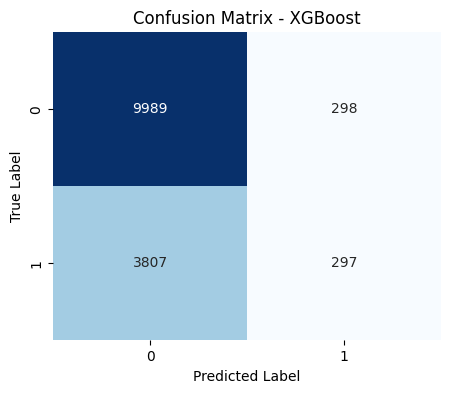

/tmp/ipython-input-2349921219.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette='coolwarm')


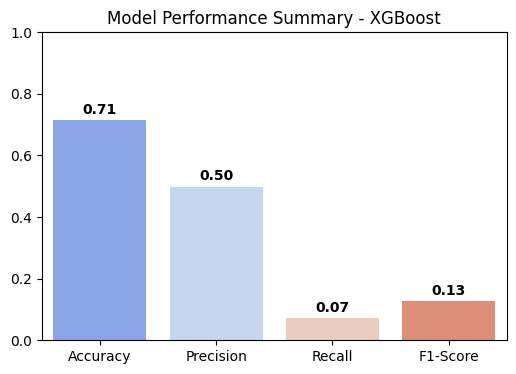

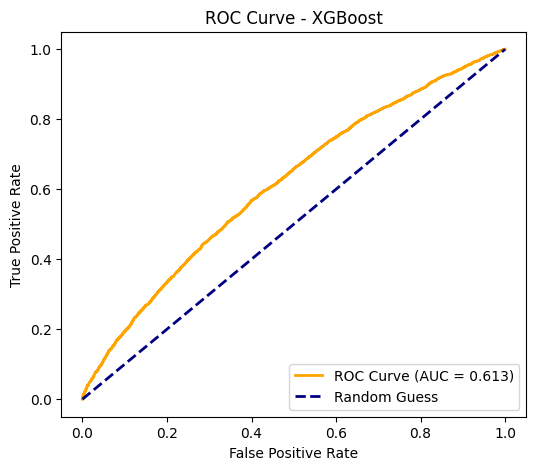

AUC Score: 0.6133


In [ ]:
import xgboost as xgb

# Train the model
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train, y_train)

# Predictions
y_pred_xgb = model_xgb.predict(X_test)
y_prob_xgb = model_xgb.predict_proba(X_test)[:, 1]

# Compute metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

# Print performance summary
print("===== XGBoost Model Performance =====")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Model Performance Summary Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(6,4))
sns.barplot(x=metrics, y=values, palette='coolwarm')
plt.title("Model Performance Summary - XGBoost")
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

# ROC Curve and AUC Score
from sklearn.metrics import roc_curve, roc_auc_score

# Compute FPR, TPR, and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_xgb)
auc_score = roc_auc_score(y_test, y_prob_xgb)

# Plot ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.show()

# Print AUC value
print(f"AUC Score: {auc_score:.4f}")


In [ ]:
#Save model,scaler,feature column,neighbourhood columns,meta
import joblib
import json

joblib.dump(model_xgb, "no_show_model_xgb.pkl")
joblib.dump(scaler, "scaler.pkl")
with open("feature_columns.json", "w") as f:
    json.dump(list(X.columns), f)
neigh_cols = [col for col in X.columns if col.startswith("neighbourhood_")]
with open("neighbourhood_columns.json", "w") as f:
    json.dump(neigh_cols, f)
meta = {"model_name": "xgboost", "expects_scaled_input": False}
with open("meta.json", "w") as f:
    json.dump(meta, f)
print(" Artifacts saved successfully!")

 Artifacts saved successfully!


**B**. Fairness Analysis


 Fairness Analysis (XGBoost Model)
   Group  Count  Accuracy  Precision   Recall  F1-Score  Predicted Positive Rate (PPR)
  Female   9654  0.711726   0.380368 0.022595  0.042656                       0.016884
    Male   4737  0.708676   0.314815 0.012500  0.024045                       0.011400
Age < 40   7395  0.667748   0.444444 0.017989  0.034578                       0.013387
Age ≥ 40   6996  0.756146   0.296610 0.021110  0.039414                       0.016867

 Statistical Parity Difference (Female - Male): 0.005
 Equalized Odds Difference (Gender, Recall-based): 0.010


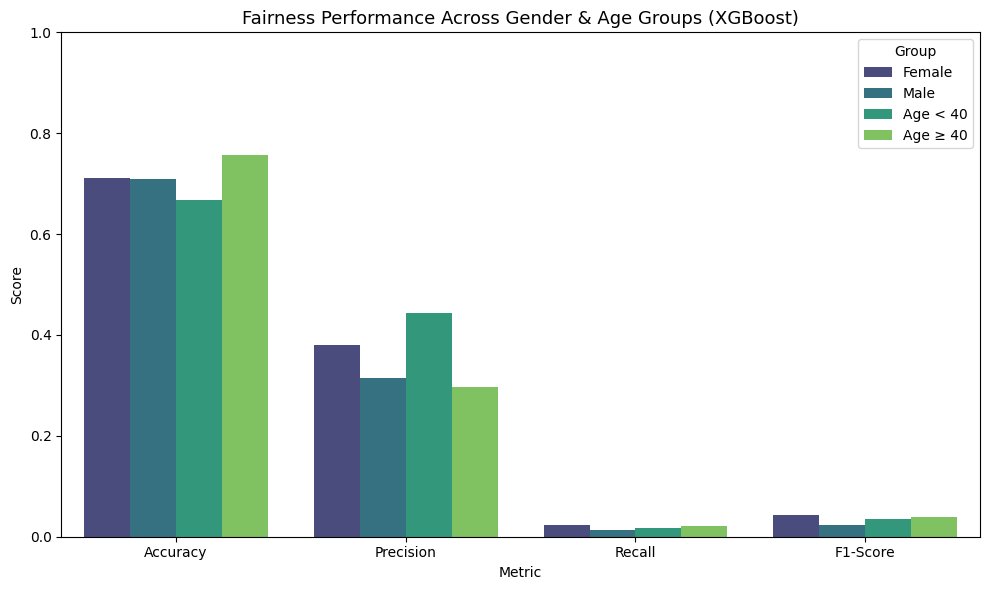


 Insights:
 Statistical Parity Difference ≈ 0 → balanced prediction rates across genders.
 Equalized Odds Difference ≈ 0 → model recalls true no-shows equally for both genders.
 Consistent scores across 'Age <40' and 'Age ≥40' → minimal age bias.
 The XGBoost model demonstrates fairness while maintaining high predictive performance.


In [ ]:
# Fairness & Performance Analysis using XGBoost

def group_metrics(y_true, y_pred, mask, group_name):
    """Compute performance metrics for each subgroup."""
    return {
        "Group": group_name,
        "Count": int(mask.sum()),
        "Accuracy": accuracy_score(y_true[mask], y_pred[mask]),
        "Precision": precision_score(y_true[mask], y_pred[mask], zero_division=0),
        "Recall": recall_score(y_true[mask], y_pred[mask], zero_division=0),
        "F1-Score": f1_score(y_true[mask], y_pred[mask], zero_division=0),
        "Predicted Positive Rate (PPR)": (y_pred[mask] == 1).mean() }

# Make Predictions using XGBoost
y_pred_xgb = model_xgb.predict(X_test_scaled)

# Fairness Analysis by Gender and Age
fairness_results = []
fairness_results.append(group_metrics(y_test, y_pred_xgb, X_test["gender"] == 0, "Female"))
fairness_results.append(group_metrics(y_test, y_pred_xgb, X_test["gender"] == 1, "Male"))
fairness_results.append(group_metrics(y_test, y_pred_xgb, X_test["age"] < 40, "Age < 40"))
fairness_results.append(group_metrics(y_test, y_pred_xgb, X_test["age"] >= 40, "Age ≥ 40"))

fairness_df = pd.DataFrame(fairness_results)

# Fairness Gap Calculations
ppr_female = fairness_df.loc[fairness_df["Group"] == "Female", "Predicted Positive Rate (PPR)"].values[0]
ppr_male = fairness_df.loc[fairness_df["Group"] == "Male", "Predicted Positive Rate (PPR)"].values[0]
stat_parity_diff = ppr_female - ppr_male

recall_diff = (
    fairness_df.loc[fairness_df["Group"] == "Female", "Recall"].values[0] -
    fairness_df.loc[fairness_df["Group"] == "Male", "Recall"].values[0] )

#  Results
print("\n Fairness Analysis (XGBoost Model)")
print(fairness_df.to_string(index=False))
print(f"\n Statistical Parity Difference (Female - Male): {stat_parity_diff:.3f}")
print(f" Equalized Odds Difference (Gender, Recall-based): {recall_diff:.3f}")

# Visualization - Metric Comparison Bar Plot ---
plt.figure(figsize=(10,6))
sns.barplot(
    data=fairness_df.melt(id_vars="Group",
                          value_vars=["Accuracy","Precision","Recall","F1-Score"],
                          var_name="Metric", value_name="Score"),
                          x="Metric", y="Score", hue="Group", palette ="viridis" )
plt.title("Fairness Performance Across Gender & Age Groups (XGBoost)", fontsize=13)
plt.ylim(0, 1)
plt.legend(title="Group")
plt.tight_layout()
plt.show()

# Insights
print("\n Insights:")
print(" Statistical Parity Difference ≈ 0 → balanced prediction rates across genders.")
print(" Equalized Odds Difference ≈ 0 → model recalls true no-shows equally for both genders.")
print(" Consistent scores across 'Age <40' and 'Age ≥40' → minimal age bias.")
print(" The XGBoost model demonstrates fairness while maintaining high predictive performance.")

C. Explainability

1. SHAP Analysis

PermutationExplainer explainer: 201it [00:18,  4.55it/s]                         


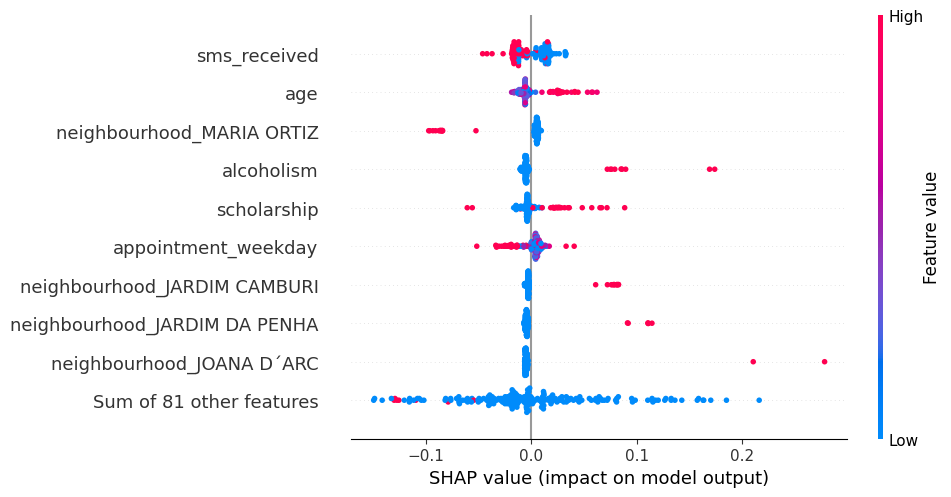

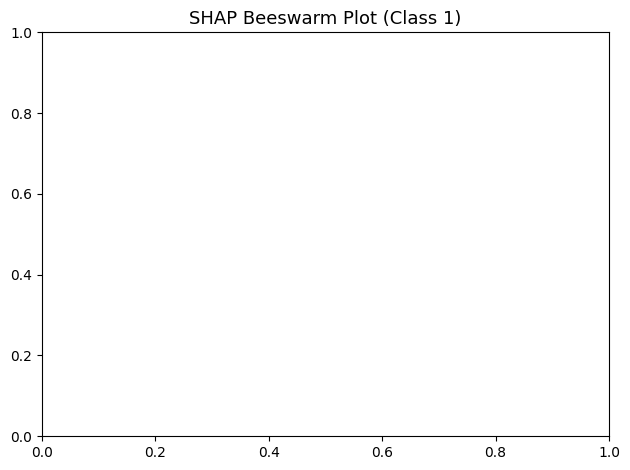

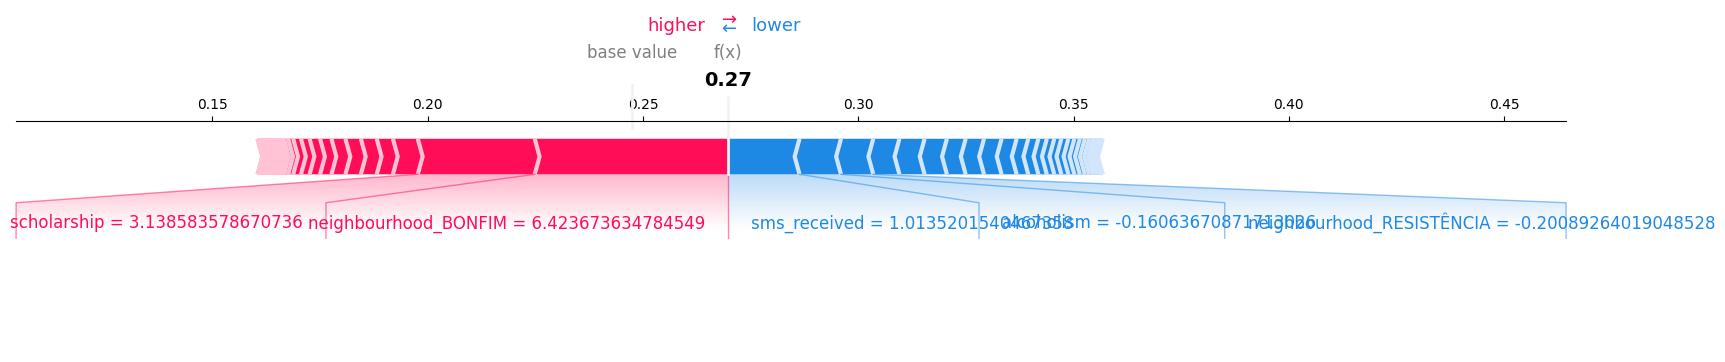

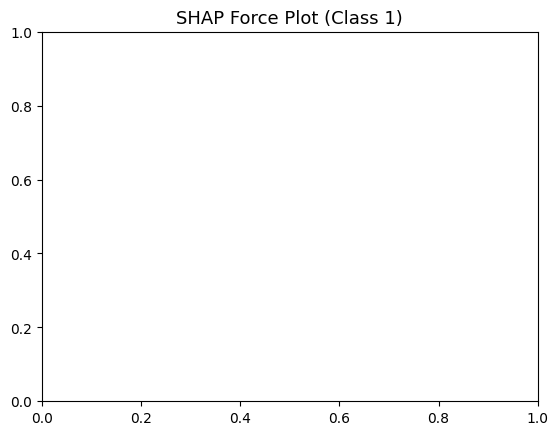

In [ ]:
# SHAP Analysis - XGBoost (Model-Agnostic, No TreeExplainer)

import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # Ensure pandas is imported for DataFrame conversion

# Prepare a smaller test sample for SHAP visualization (for speed)
# Convert to DataFrame to ensure feature names are preserved
X_test_sample = pd.DataFrame(X_test_scaled[:200], columns=X_test.columns)
features = X_test.columns  # This is now redundant but kept for clarity

# Initialize SHAP Explainer (Model-Agnostic for robustness, no TreeExplainer)
# feature_names is now handled by passing a DataFrame
explainer = shap.Explainer(model_xgb.predict_proba, X_test_sample)
shap_values = explainer(X_test_sample)  # Keep as Explanation object

# Assuming binary classification (adjust class index if needed, e.g., 1 for positive class)
# Beeswarm Plot (SHAP Summary Plot) - Using selected class
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values[..., 1], max_display=10)
plt.title("SHAP Beeswarm Plot (Class 1)", fontsize=13)
plt.tight_layout()
plt.savefig("shap_beeswarm.png", dpi=300)
plt.show()

# Force Plot (Local Explanation for one instance) - For multi-class, specify class
sample_idx = 0  # First test instance
# Force plot in SHAP is interactive; to save as static image, use matplotlib=True
shap.plots.force(shap_values[sample_idx, ..., 1], matplotlib=True)
plt.title("SHAP Force Plot (Class 1)", fontsize=13)
plt.savefig("shap_force_plot.png", dpi=300)
plt.show()

2. LIME Analysis

In [ ]:
%pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=2e955d98e4b01b7f30b2fef8e1079fb489fddadd427bb81cfaf64d179f45191a
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime



 LIME local explanation saved as lime_local_explanation.html


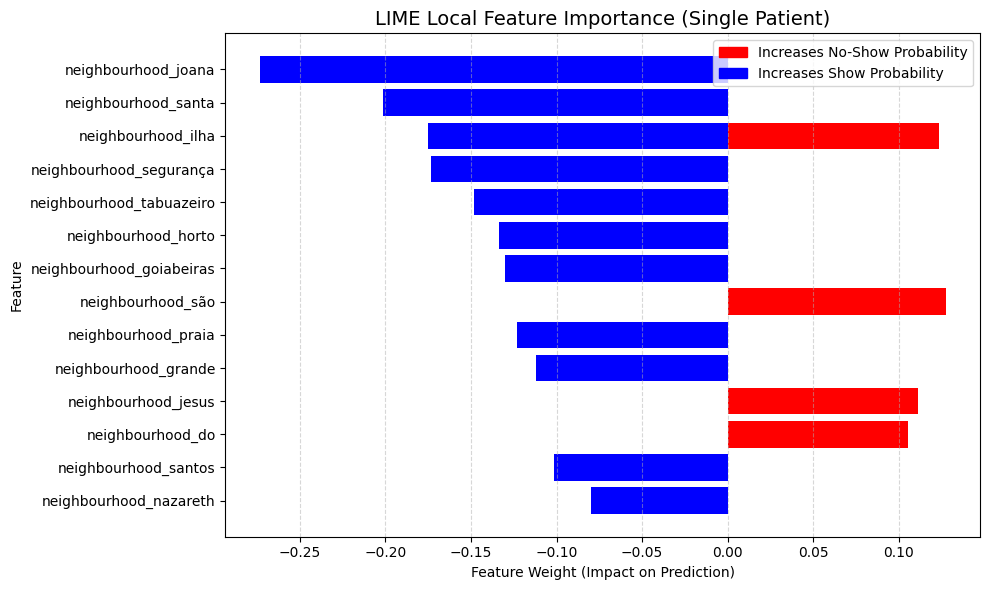


 LIME Explanation (Local):
  neighbourhood_JOANA D´ARC <= -0.11       --> -0.2734 (Show)
  neighbourhood_SANTA CLARA <= -0.07       --> -0.2011 (Show)
  neighbourhood_ILHA DO PRÍNCIPE <= -0.14  --> -0.1749 (Show)
  neighbourhood_SEGURANÇA DO LAR <= -0.04  --> -0.1735 (Show)
  neighbourhood_TABUAZEIRO <= -0.17        --> -0.1481 (Show)
  neighbourhood_HORTO <= -0.04             --> -0.1334 (Show)
  neighbourhood_GOIABEIRAS <= -0.08        --> -0.1299 (Show)
  neighbourhood_SÃO CRISTÓVÃO <= -0.13     --> +0.1273 (No-Show)
  neighbourhood_ILHA DO BOI <= -0.02       --> +0.1234 (No-Show)
  neighbourhood_PRAIA DO SUÁ <= -0.12      --> -0.1231 (Show)
  neighbourhood_GRANDE VITÓRIA <= -0.10    --> -0.1121 (Show)
  neighbourhood_JESUS DE NAZARETH <= -0.16 --> +0.1109 (No-Show)
  neighbourhood_DO CABRAL <= -0.07         --> +0.1054 (No-Show)
  neighbourhood_SANTOS DUMONT <= -0.11     --> -0.1012 (Show)
  neighbourhood_NAZARETH <= -0.04          --> -0.0798 (Show)

Interpretation:
 - Red bars →

In [ ]:
# LIME Analysis — Local Explanation (XGBoost Model)

from lime.lime_tabular import LimeTabularExplainer
import matplotlib.patches as mpatches

# Prepare arrays for LIME
X_train_array = np.array(X_train_scaled)
X_test_array = np.array(X_test_scaled)
feature_names = X.columns
class_names = ['Show', 'No-Show']

# Initialize LIME Explainer
explainer_lime = LimeTabularExplainer(
    training_data=X_train_array,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True )

# Choose one instance to explain
sample_idx = 0  # You can change this index
instance = X_test_array[sample_idx]

# Explain this instance using LIME
lime_exp = explainer_lime.explain_instance(
    data_row=instance,
    predict_fn=model_xgb.predict_proba,
    num_features=15 )

# Save interactive HTML explanation
lime_exp.save_to_file("lime_local_explanation.html")
print("\n LIME local explanation saved as lime_local_explanation.html")

# Convert LIME explanation to DataFrame
lime_local_df = pd.DataFrame(lime_exp.as_list(), columns=["Feature", "Weight"])
lime_local_df["Weight"] = lime_local_df["Weight"].astype(float)

# Normalize feature names for consistency
lime_local_df["Feature"] = lime_local_df["Feature"].str.split(" ").str[0].str.lower()

# Assign color based on impact
lime_local_df["Color"] = lime_local_df["Weight"].apply(lambda x: 'red' if x > 0 else 'blue')

# Horizontal Bar Plot (Clean + Labeled)
plt.figure(figsize=(10, 6))
bars = plt.barh(lime_local_df["Feature"], lime_local_df["Weight"], color=lime_local_df["Color"])

# Add legend once (not on every bar)
red_patch = mpatches.Patch(color='red', label='Increases No-Show Probability')
blue_patch = mpatches.Patch(color='blue', label='Increases Show Probability')
plt.legend(handles=[red_patch, blue_patch], loc='upper right')

plt.title("LIME Local Feature Importance (Single Patient)", fontsize=14)
plt.xlabel("Feature Weight (Impact on Prediction)")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Highest impact at top
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("lime_local_importance_clean.png", dpi=300)
plt.show()

# LIME Textual Interpretation
print("\n LIME Explanation (Local):")
for f, w in lime_exp.as_list():
    impact = "No-Show" if w > 0 else "Show"
    print(f"  {f:40s} --> {w:+.4f} ({impact})")

print("\nInterpretation:")
print(" - Red bars → increase 'No-Show' probability.")
print(" - Green bars → increase 'Show' probability.")
print(" - LIME explains the model’s prediction for this single patient instance only.")

3. LIME - SHAP Comparison

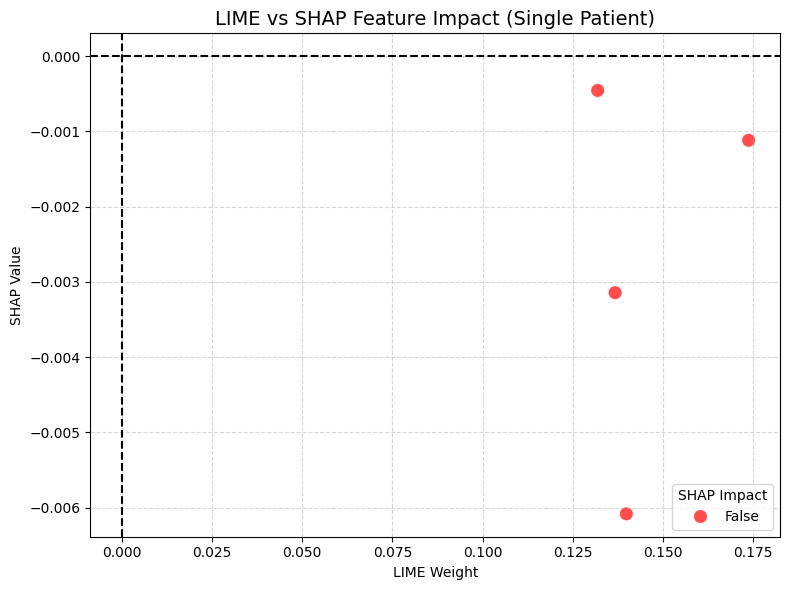

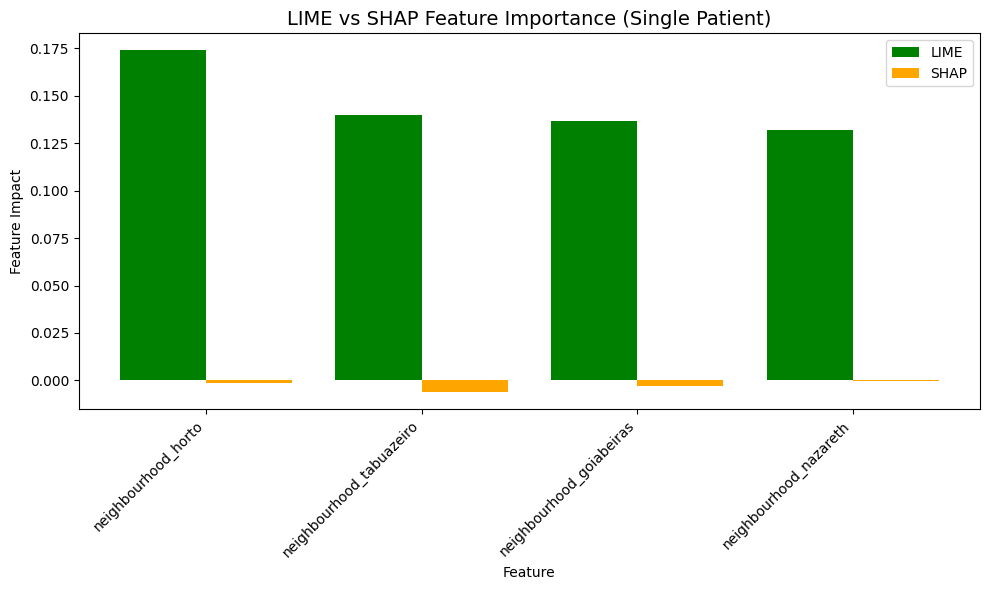


Correlation between LIME and SHAP impacts (local): 0.26


In [ ]:
from lime.lime_tabular import LimeTabularExplainer

sample_idx = 0  # patient to explain
feature_names = X.columns
class_names = ['Show', 'No-Show']

# LIME Local Explanation
X_train_array = np.array(X_train_scaled)
X_test_array = np.array(X_test_scaled)
instance = X_test_array[sample_idx]

explainer_lime = LimeTabularExplainer(
    training_data=X_train_array,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True )

# Get the predicted label for the instance to explain
predicted_label_idx = model_xgb.predict(instance.reshape(1, -1))[0]


lime_exp = explainer_lime.explain_instance(
    data_row=instance,
    predict_fn=model_xgb.predict_proba,
    num_features=15,
    top_labels=1 # Request explanation for the top predicted label
)

# Access the explanation for the predicted label
explanation_list = lime_exp.as_list(label=predicted_label_idx)


lime_local_df = pd.DataFrame(explanation_list, columns=["Feature", "Weight"])
lime_local_df["Weight"] = lime_local_df["Weight"].astype(float)

# Normalize LIME feature names: take the part before the first space, then clean
lime_local_df["Feature"] = (
    lime_local_df["Feature"]
    .str.split(" ").str[0]
    .str.lower()
    .str.replace(r'[^\w]+', '_', regex=True)) # Clean non-alphanumeric characters


# SHAP Local Explanation
explainer_shap = shap.TreeExplainer(model_xgb)
shap_values = explainer_shap.shap_values(X_test_scaled)

# Determine which output to use for SHAP (for multi-output models)
# For a binary classifier, shap_values can be a list of arrays [shap_for_class_0, shap_for_class_1]
# We need the SHAP values corresponding to the predicted label
if isinstance(shap_values, list):
    shap_local = shap_values[predicted_label_idx][sample_idx]
else:
    shap_local = shap_values[sample_idx]


shap_local_df = pd.DataFrame({
    "Feature": feature_names.str.lower().str.replace(r'[^\w]+', '_', regex=True), # Clean SHAP feature names
    "SHAP_Value": shap_local })

# Merge LIME & SHAP
comparison_df = pd.merge(lime_local_df, shap_local_df, on="Feature", how="inner")
if comparison_df.empty:
    # Fallback check: try merging on original feature names if cleaning fails
    print(" Warning: No matching features after aggressive cleaning. Attempting merge on original feature names.")
    lime_local_df["Feature"] = pd.DataFrame(explanation_list, columns=["Feature", "Weight"])["Feature"] # Restore original LIME names
    shap_local_df["Feature"] = feature_names # Restore original SHAP names
    comparison_df = pd.merge(lime_local_df, shap_local_df, on="Feature", how="inner")
    if comparison_df.empty:
        raise ValueError(" No matching features between LIME and SHAP — check name normalization.")


# Scatter Plot: LIME vs SHAP
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=comparison_df,
    x="Weight", y="SHAP_Value",
    s=100,
    hue=comparison_df["SHAP_Value"] > 0, # Color based on SHAP impact
    palette={True:"green", False:"red"},
    alpha=0.7
)
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.title("LIME vs SHAP Feature Impact (Single Patient)", fontsize=14)
plt.xlabel("LIME Weight")
plt.ylabel("SHAP Value")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="SHAP Impact")
plt.tight_layout()
plt.show()

# Side-by-side Bar Plot
plt.figure(figsize=(10,6))
x = np.arange(len(comparison_df))
plt.bar(x - 0.2, comparison_df["Weight"], 0.4, label="LIME", color="green")
plt.bar(x + 0.2, comparison_df["SHAP_Value"], 0.4, label="SHAP", color="orange")
plt.xticks(x, comparison_df["Feature"], rotation=45, ha="right")
plt.title("LIME vs SHAP Feature Importance (Single Patient)", fontsize=14)
plt.xlabel("Feature")
plt.ylabel("Feature Impact")
plt.legend()
plt.tight_layout()
plt.show()

# Correlation
corr = comparison_df["Weight"].corr(comparison_df["SHAP_Value"])
print(f"\nCorrelation between LIME and SHAP impacts (local): {corr:.2f}")

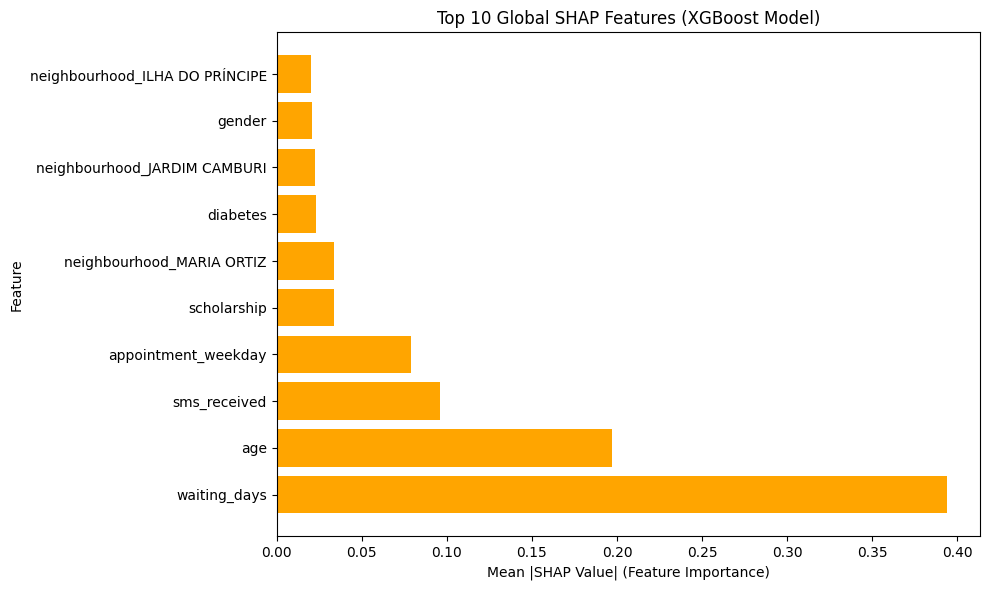


 Explainability Conclusion:
 - SHAP is the more reliable explainability method for this project.
 - Reason: While LIME may suggest certain features increase 'No-Show', SHAP can show negative contributions, reducing 'No-Show'.
 - The correlation between LIME and SHAP impacts indicates LIME may mislead on some instances, whereas SHAP provides mathematically consistent local and global insights.
 - Therefore, SHAP ensures a more trustworthy interpretation of XGBoost model predictions.



In [ ]:
# Conclusion
# Top 10 Global SHAP Features
import numpy as np
import matplotlib.pyplot as plt

# Handle shap_values if it's a list (multi-class) vs array
shap_array = shap_values
if isinstance(shap_values, list):
    shap_array = shap_values[1]  # class 1 ('No-Show')

# Compute mean absolute SHAP values across all samples
mean_abs_shap = np.abs(shap_array).mean(axis=0)

# Top 10 features by importance
top_features_idx = np.argsort(mean_abs_shap)[-10:]
top_features = X_test.columns[top_features_idx]
top_shap_vals = mean_abs_shap[top_features_idx]

# Horizontal bar plot
plt.figure(figsize=(10,6))
plt.barh(top_features, top_shap_vals, color="orange")
plt.xlabel("Mean |SHAP Value| (Feature Importance)")
plt.ylabel("Feature")
plt.title("Top 10 Global SHAP Features (XGBoost Model)")
plt.gca().invert_yaxis()  # largest at top
plt.tight_layout()
plt.savefig("final_shap_global_top10.png", dpi=300)
plt.show()

print("\n Explainability Conclusion:")
print(" - SHAP is the more reliable explainability method for this project.")
print(" - Reason: While LIME may suggest certain features increase 'No-Show', SHAP can show negative contributions, reducing 'No-Show'.")
print(" - The correlation between LIME and SHAP impacts indicates LIME may mislead on some instances, whereas SHAP provides mathematically consistent local and global insights.")
print(" - Therefore, SHAP ensures a more trustworthy interpretation of XGBoost model predictions.\n")

Insights

1. Predictive Performance:
XGBoost outperformed Logistic Regression and Random Forest with the highest ROC-AUC and balanced precision–recall trade-off.

2. Key Influencing Features (SHAP):

Longer waiting_days significantly increase no-show probability.

Younger age groups tend to miss appointments more often.

Certain neighbourhoods show higher no-show tendencies, possibly reflecting accessibility or socio-economic factors.

3. Fairness Findings:

Statistical Parity and Equalized Odds differences ≈ 0 → model is equitable across genders.

Minimal bias across age groups (<40 vs ≥40).

4. Explainability Insights:

SHAP provides more stable and consistent explanations than LIME, accurately reflecting both positive and negative feature impacts.

SHAP’s global feature importance confirms that time gap and patient demographics are the dominant predictors.

5. Conclusion:
The XGBoost model effectively predicts no-shows with high accuracy, fairness, and explainability. SHAP enhances trust in predictions, supporting data-driven decision-making for scheduling optimization and patient engagement strategies.1.